In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# I am using Pytorch BTW.
import torch
from torch import nn
import torch.nn.functional as F

from tqdm import trange

%matplotlib inline
import matplotlib.pyplot as plt

# pip install madgrad
from madgrad import MADGRAD
from pcgrad import PCGrad

In [2]:
class NMF(nn.Module):
    def __init__(self, B, N, K):
        super(NMF, self).__init__()
        self.W = nn.Parameter(torch.rand(B, K, requires_grad=True, dtype=torch.float32))
        self.H = nn.Parameter(torch.rand(K, N, requires_grad=True, dtype=torch.float32))
        torch.nn.init.kaiming_uniform_(self.W, a=0, mode='fan_in', nonlinearity='relu')
        torch.nn.init.kaiming_uniform_(self.H, a=0, mode='fan_in', nonlinearity='relu')
    def forward(self):
        return torch.matmul(self.W, self.H)

n_components = 6

# Simulated data
B = 1000; N = 32; K = n_components
Y = torch.rand(B, N)

In [3]:
# Real data
data = pd.read_csv('conc_data.csv', index_col=None)
uncerts = pd.read_csv('unc_data.csv', index_col=None)

del data['Date']
del uncerts['Date']

species = data.columns
uncerts = (uncerts.values)
confidences = torch.tensor(1/uncerts).float().requires_grad_(False)

B, N = data.shape
K = n_components
Y = torch.tensor(data.values).float().requires_grad_(False)

nmf = NMF(B, N, K)

In [4]:
# (confidences-confidences.min())/(confidences.max()-confidences.min())

In [5]:
optimizer = MADGRAD(nmf.parameters(), lr=1e-3, momentum=0.95)
# optimizer = PCGrad(torch.optim.SGD(nmf.parameters(), lr=1e-3, momentum=0.95))

epochs = 20000

for i in trange(epochs):
    optimizer.zero_grad()
    
    preds = nmf()
#     err = confidences*(Y-preds)
    err = confidences*(Y-preds)
    fro = torch.linalg.norm(err, 'fro')
#     ortho_loss = F.mse_loss((nmf.H@nmf.H.T), torch.eye(K))

    fro.backward()
    optimizer.step()
    
    nmf.W.data = F.relu(nmf.W.data)
    nmf.H.data = F.relu(nmf.H.data)

100%|██████████| 20000/20000 [00:12<00:00, 1581.34it/s]


In [6]:
nmf.eval()
chk_loss = ((Y-nmf())**2).mean()
chk_loss.item()

0.2850215435028076

#### Compare the performance with the Sklearn NMF function, giving close optimal solution

In [7]:
from sklearn.decomposition import NMF

In [8]:
model = NMF(n_components=K, init='random', random_state=0)
W = model.fit_transform(Y.detach().numpy())
H = model.components_

In [9]:
((W@H-Y.detach().numpy())**2).mean()

0.00848233529481921

In [10]:
H_array = nmf.H.detach().numpy()
interested_species = species[H_array.sum(axis=0)>0.0]
interested_H_array = H_array[:, H_array.sum(axis=0)>0.0]
interested_H_array = 100*interested_H_array/interested_H_array.sum(axis=0)

In [11]:
contributions = nmf.W.data.sum(axis=0)
contributions = 100*contributions/contributions.sum()
contributions

tensor([ 7.5706, 15.9694, 39.8007, 16.8629,  6.8741, 12.9222])

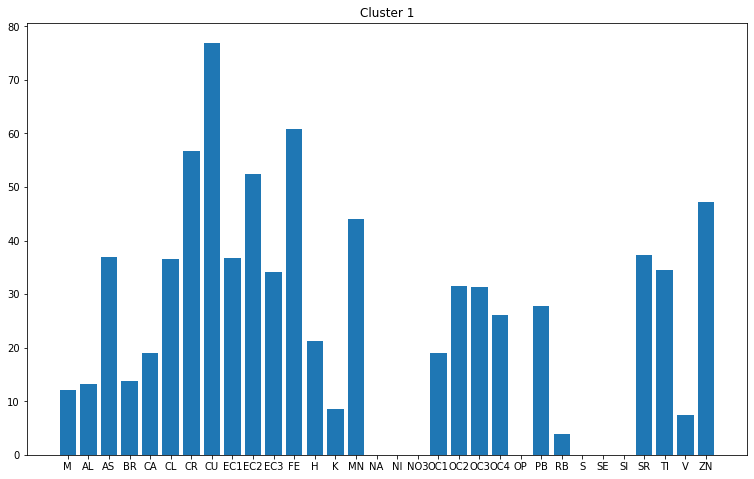

In [12]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(interested_species), list(interested_H_array[0, :]))
plt.title("Cluster 1")
plt.show()

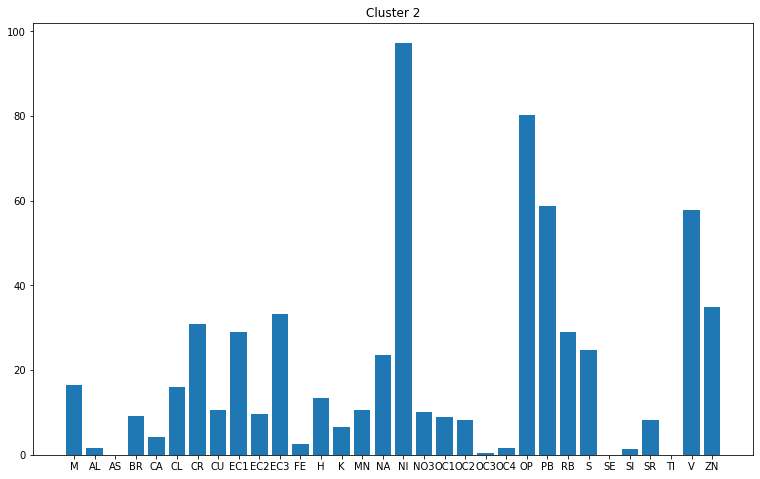

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(interested_species), list(interested_H_array[1, :]))
plt.title("Cluster 2")
plt.show()

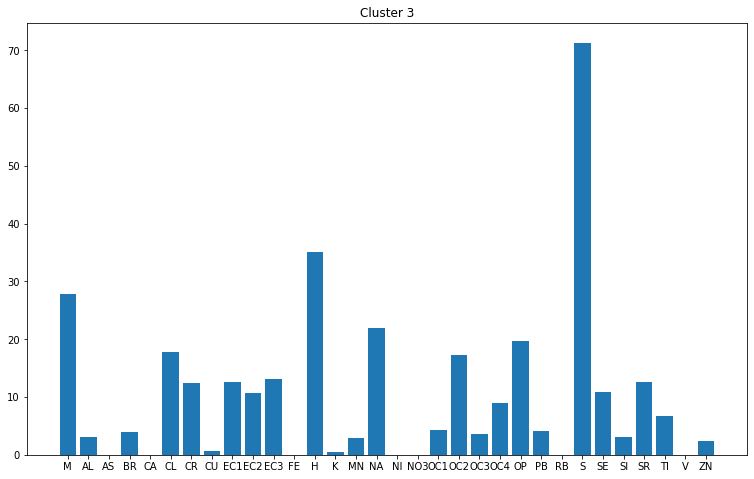

In [14]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(interested_species), list(interested_H_array[2, :]))
plt.title("Cluster 3")
plt.show()

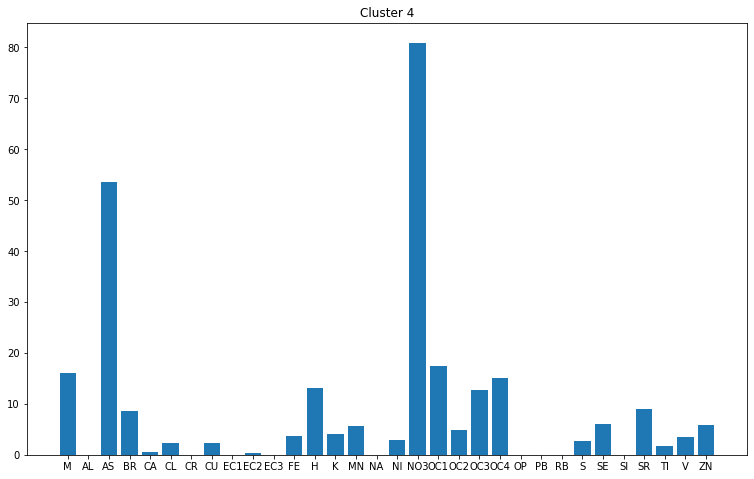

In [15]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(interested_species), list(interested_H_array[3, :]))
plt.title("Cluster 4")
plt.show()

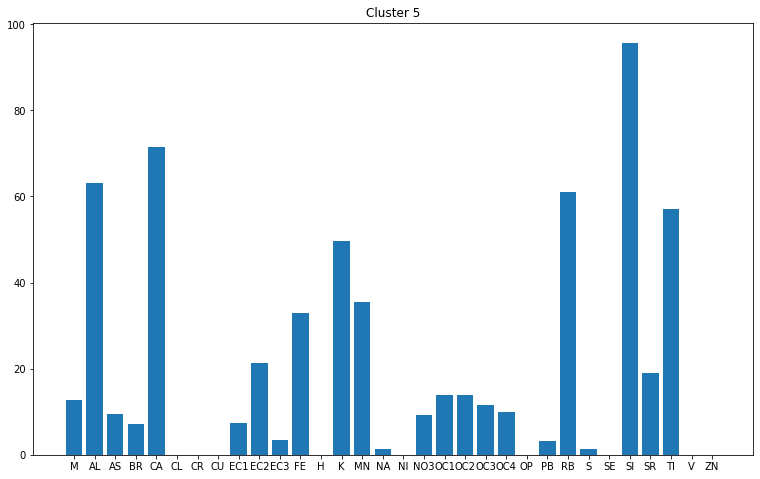

In [16]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(interested_species), list(interested_H_array[4, :]))
plt.title("Cluster 5")
plt.show()

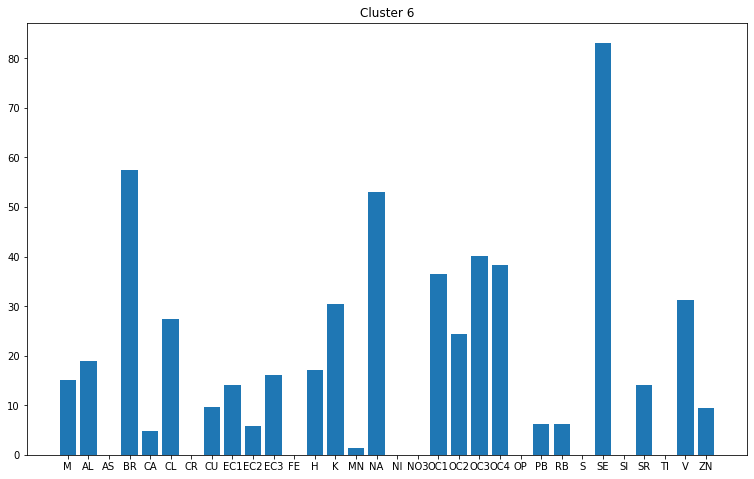

In [17]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(interested_species), list(interested_H_array[5, :]))
plt.title("Cluster 6")
plt.show()